In [ ]:
# 4 agents: renewable, gas exit, gas entry, coal exit

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import gamma
from scipy.stats import beta
from scipy.linalg import block_diag
import random

In [2]:
# interval
Smin = 0.1
Smax = 0.7
Cmin = 0
Cmax = 120
tmin = 0
tmax = 30

# number for points
NS = 41
NC = 41
Nt = 101

# discretization
dS = 1.*(Smax-Smin)/(NS-1)
dC = 1.*(Cmax-Cmin)/(NC-1)
dt = 1.*(tmax-tmin)/(Nt-1)

# define grid in space
S = np.linspace(Smin,Smax,NS)
C = np.linspace(Cmin,Cmax,NC)
T = np.linspace(tmin,tmax,Nt)

# long-term average cost
theta_G = 37.94
theta_C = 22.5
theta_R = 0.4

# standard deviation
std_G = 12.53
std_C = 10
std_R = 0.075

# rate of mean reversion
kG = 0.5
kC = 0.5
kR = 0.5

# variability of the cost process 
delta_G = std_G*np.sqrt(2.*kG/theta_G)
delta_C = std_C*np.sqrt(2.*kC/theta_C)
delta_R = std_R*np.sqrt(2.*kR/(theta_R*(1-theta_R)-std_R*std_R))

rho = 0.08

epsilon = 0.5

# depreciation rate
gamma_G = np.log(2.)/15.
gamma_C = np.log(2.)/20.
gamma_R = np.log(2.)/12.5

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000. 

# maximal price 
P = 150.

K_R = 1500. # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G_enter = 1450 # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)
K_C = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)

# fixed cost
k_G = 42. # per kW per year
k_C = 68. # per kW per year
k_R = 30. # per kW per year

# coef carbon emission (tCO2/kWh)
ctax_G = 0.429
ctax_C = 0.986

# initial condition gas producers who exit
alpha_G = (theta_G/std_G)*(theta_G/std_G)
beta_G = theta_G/std_G/std_G
InitialOmega = 32*beta_G*gamma.pdf(beta_G*C,alpha_G)
# initial condition gas producers who enter
InitialLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)
BarLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)

# initial condition coal producers who exit
alpha_C = (theta_C/std_C)*(theta_C/std_C)
beta_C = theta_C/std_C/std_C
InitialMu = 44.9*beta_C*gamma.pdf(beta_C*C,alpha_C)

# initial condition renewable producers
alpha_R = theta_R*(theta_R*(1.-theta_R)/std_R/std_R-1.)
beta_R = (1.-theta_R)*(theta_R*(1.-theta_R)/std_R/std_R-1.)
BarEta = 118.3*beta.pdf(S,alpha_R,beta_R)
InitialEta = 64.*beta.pdf(S,alpha_R,beta_R)

# demand
demand = np.array([58.17932923,58.17932923,58.17932923,58.17932923
                    ,58.00821355,58.00821355,58.00821355,58.00821355
                    ,57.3709788,57.3709788,57.3709788,57.3709788
                    ,57.6659822,57.6659822,57.6659822,57.6659822
                    ,57.49486653,57.49486653,57.49486653,57.49486653
                    ,57.32375086,57.32375086,57.32375086,57.32375086
                    ,57.15263518,57.15263518,57.15263518,57.15263518
                    ,56.98151951,56.98151951,56.98151951,56.98151951
                    ,56.81040383,56.81040383,56.81040383,56.81040383
                    ,56.63928816,56.63928816,56.63928816,56.63928816
                    ,56.46817248,56.46817248,56.46817248,56.46817248
                    ,56.39972621,56.39972621,56.39972621,56.39972621
                    ,56.33127995,56.33127995,56.33127995,56.33127995
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.19438741,56.19438741,56.19438741,56.19438741
                    ,56.12594114,56.12594114,56.12594114,56.12594114
                    ,56.05749487,56.05749487,56.05749487,56.05749487
                    ,55.9890486,55.9890486,55.9890486,55.9890486
                    ,55.92060233,55.92060233,55.92060233,55.92060233
                    ,55.85215606,55.85215606,55.85215606,55.85215606
                    ,55.78370979,55.78370979,55.78370979,55.78370979
                    ,55.86356377,55.86356377,55.86356377,55.86356377
                    ,55.94341775,55.94341775,55.94341775,55.94341775
                    ,56.02327173,56.02327173,56.02327173,56.02327173
                    ,56.10312571,56.10312571,56.10312571,56.10312571
                    ,56.18297969,56.18297969,56.18297969,56.18297969
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.34268766,56.34268766,56.34268766,56.34268766
                    ,56.42254164,56.42254164,56.42254164,56.42254164
                    ,56.50239562,56.50239562,56.50239562,56.50239562
                    ,56.5822496,56.5822496,56.5822496,56.5822496])

# Adjusting for seasonal cycle
sc = np.array([[1.052491152, 0.962461095, 0.953705412, 1.037144059]])

sc = np.repeat(sc,len(demand)/4,axis=0)
sc = np.reshape(sc,1*len(demand))
demand[:101] = demand[:101]*sc[:101]
demand[100] = demand[100]*sc[0]

# peak / offpeak demand ratio
Dc = 1.257580634655325

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)

# fonction G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+x*x/2/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(X):
    return 17.5*X/150.

# fonction ptax - price carbon tax
def ptax(t):
    return 5.*t-10050 

# fonction g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x) - ctax_G*ptax(2020+t)*F(p-x) - k_G - (rho+gamma_G)*K_G*np.exp(-gamma_G*t)

# function h - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + ctax_G*ptax(2020+t)*F(p-x) + k_G + rho*K_G_enter + gamma_G*K_G_enter*np.exp(-(rho+gamma_G)*(tmax-t))

# fonction f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + k_R + rho*K_R + gamma_R*K_R*np.exp(-(rho+gamma_R)*(tmax-t))

# fonction l - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x) - ctax_C*ptax(2020+t)*F(p-x) - k_C - (rho+gamma_C)*K_C*np.exp(-gamma_C*t)

# residual demand
def computeR(eta,dem):
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    Eta = np.reshape(eta,(Nt,NS))
    R = dem[:Nt]+np.matmul(Eta,S)*dS-maxdem
    return (R[:Nt]*(R[:Nt]>0))

# total supply by the conventional gas producers at prive level p
def computeM(l, p):
    maxdem = sum(F(p-C[:-1])*BarLambda[0:NC-1])*dC
    Lamb = np.reshape(l,(Nt,NS))
    M = maxdem - np.matmul(Lamb,F(p-C))*dC    
    return M 

# function which computes the price for given densities at a given time t
def price(t,R,O,L,M):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(O[t*NC:(t+1)*NC]+M[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(L,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root 

################################################################################################################
# find the maximum on omega at a given iteration
################################################################################################################
def OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega
    
    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})

    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on lambda at a given iteration
################################################################################################################
def OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C,Prp[i],T[i])+opcoef*h(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    
    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialLambda

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Lambda[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on eta at a given iteration
################################################################################################################
def OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))        
    
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+delta_R*delta_R*S*(1-S)*dt/(dS*dS)
    barV1 = -delta_R*delta_R*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+kR*(theta_R-S[1:])*dt/(2*dS)
    barV2 = -delta_R*delta_R*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-kR*(theta_R-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2

    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})
    if(res.status): print('OpEntry: '+res.message)

    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on mu at a given iteration
################################################################################################################
def OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*l(C,Prp[i],T[i])+opcoef*l(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_C*delta_C*C*dt/(dC*dC)
    V1 =-delta_C*delta_C*C[1:]*dt/(2*dC*dC)+kC*(theta_C-C[1:])*dt/(2*dC)
    V2=-delta_C*delta_C*C[:-1]*dt/(2*dC*dC)-kC*(theta_C-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Mu[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

In [3]:
start = time.time()

Niter = 200 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of mu (exit for gas)
Mu=np.zeros(Nt*NC)
Mu[:NC]=InitialMu

# initialisation of lambda (entry for gas)
Lambda=np.zeros(Nt*NC)
Lambda[:NC]=InitialLambda

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional gas exit capacity
g_exit_hist = np.zeros((Nt,Niter))
# conventional gas entry capacity
g_enter_hist = np.zeros((Nt,Niter))
# conventional coal capacity
c_hist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))
Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"

# save objectives
save_ob_G = np.zeros(Niter)
save_ob_G_enter = np.zeros(Niter)
save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)

# residual peak and off-peak demand
Rp = computeR(Eta,pdemand)
Rop = computeR(Eta,opdemand)

# stock residual peak and off-peak demand value (historical)
RRp[:,0] = Rp
RRop[:,0] = Rop

Prp = np.zeros(Nt)
Prop = np.zeros(Nt)
for j in range(Nt):
    Prp[j] = price(j,Rp,Omega,Lambda,Mu)
    Prop[j] = price(j,Rop,Omega,Lambda,Mu)
    prphist[j,0] = Prp[j]
    prophist[j,0] = Prop[j]

# initialize
ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)
print(out1.format(ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

for i in range(Niter):  

    save_ob_G[i] = ob_G
    save_ob_G_enter[i] = ob_G_enter
    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R

    if ob_R+ob_G < tol:
        print('Convergence achieved')
        Niter = i
        break

    print('Iteration ',i)   

    # reshape distribution 
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newLamb = np.reshape(Lambda,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,NC))

    g_exit_hist[:,i] = np.sum(newOm,axis=1)*dC
    g_enter_hist[:,i] = np.sum(newLamb,axis=1)*dC
    c_hist[:,i] = np.sum(newMu,axis=1)*dC
    penhist[:,i] = np.sum(newEta,axis=1)*dS
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Lambda[NC:] = (1.-weight)*Lambda[NC:]+weight*Lambda1
    Mu[NC:] = (1.-weight)*Mu[NC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # residual peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # stock residual peak and off-peak demand value (historical)
    if (i!=Niter-1):
        RRp[:,i+1] = Rp
        RRop[:,i+1] = Rop

    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)
        if (i!=Niter-1):
            prphist[j,i+1] = Prp[j]
            prophist[j,i+1] = Prop[j]

    # search the solution
    ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)

    # advancement
    print(out2.format(weight,ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

end = time.time()
elapsed = end - start

print(elapsed)

Initial Objectives: Renewable: 51814.15; Conventional gas exit:  10.87; Conventional gas enter:  64890.31; Conventional coal exit:  94.94; Total: 116810.28
Iteration  0
Weight: 1.0000; Renewable: 262804.07; Conventional gas exit:  314191.78; Conventional gas enter:  305586.85; Conventional coal exit:  461058.05; Total: 1343640.75
Iteration  1
Weight: 0.5000; Renewable: 25272.49; Conventional gas exit:  7279.34; Conventional gas enter:  32901.65; Conventional coal exit:  19068.29; Total: 84521.77
Iteration  2
Weight: 0.3333; Renewable: 8836.16; Conventional gas exit:  3128.64; Conventional gas enter:  19593.04; Conventional coal exit:  7913.67; Total: 39471.50
Iteration  3
Weight: 0.2500; Renewable: 7643.28; Conventional gas exit:  11685.93; Conventional gas enter:  7938.03; Conventional coal exit:  19178.91; Total: 46446.14
Iteration  4
Weight: 0.2000; Renewable: 11668.45; Conventional gas exit:  4642.93; Conventional gas enter:  12468.01; Conventional coal exit:  10357.49; Total: 3913

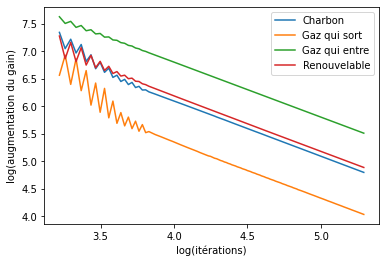

In [27]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter[24:], np.log(save_ob_C[25:]), label = "Charbon")
plt.plot(logIter[24:], np.log(save_ob_G[25:]), label = "Gaz qui sort")
plt.plot(logIter[24:], np.log(save_ob_G_enter[25:]), label = "Gaz qui entre")
plt.plot(logIter[24:], np.log(save_ob_R[25:]), label = "Renouvelable")
#plt.title("Algorithm convergence")
plt.xlabel('log(itérations)')
plt.ylabel('log(augmentation du gain)')
plt.legend()
plt.savefig("convergence")
plt.show()

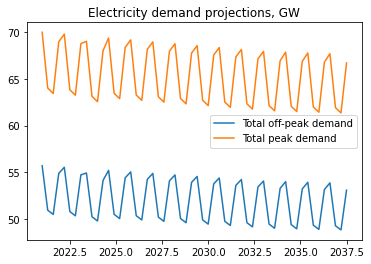

In [13]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2021+T[:56],opdemand[:56],label='Total off-peak demand')
plt.plot(2021+T[:56],pdemand[:56],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.legend()
plt.show()

Text(0.5, 0.92, 'Renewable')

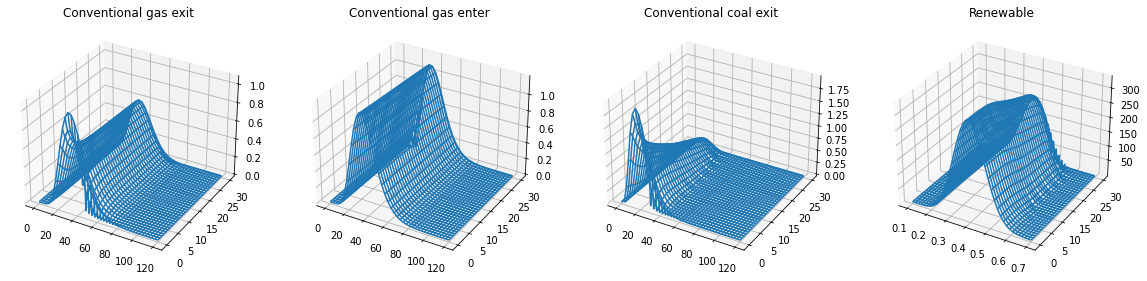

In [44]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

fig = plt.figure(figsize=(20,10))


newOm = np.reshape(Omega,(Nt,NC))
ax = fig.add_subplot(141, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newOm)
plt.title('Conventional gas exit')

newLamb = np.reshape(Lambda,(Nt,NC))
ax = fig.add_subplot(142, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newLamb)
plt.title('Conventional gas enter')

newMu = np.reshape(Mu,(Nt,NC))
ax = fig.add_subplot(143, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newMu)
plt.title('Conventional coal exit')

newEta = np.reshape(Eta,(Nt,NS))
XX, YY = np.meshgrid(S, T)
ax2 = fig.add_subplot(144, projection='3d')
ax2.plot_wireframe(XX, YY, newEta)
plt.title('Renewable')

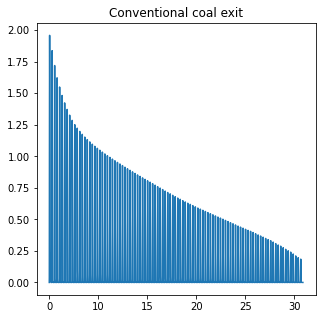

In [50]:
plt.figure(figsize=(5,5))
plt.plot(Mu)
plt.title('Conventional coal exit')
plt.xticks([0,800,1600,2400,3200,4000],[0,10,15,20,25,30])
plt.savefig('latéral_distri')


Text(0.5, 1.0, 'Renewable')

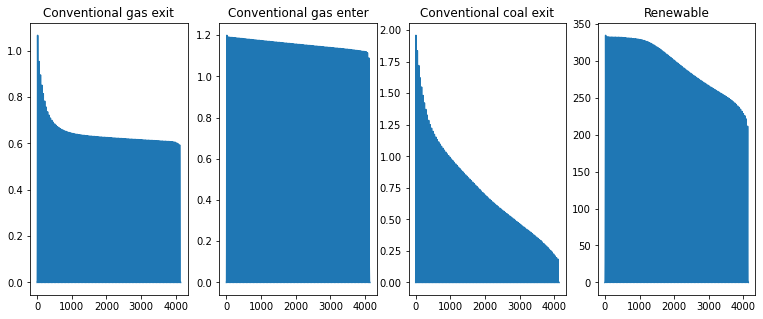

In [15]:
plt.figure(figsize=(13,5))

plt.subplot(1,4,1)
plt.plot(Omega)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
plt.plot(Lambda)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
plt.plot(Mu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
plt.plot(Eta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

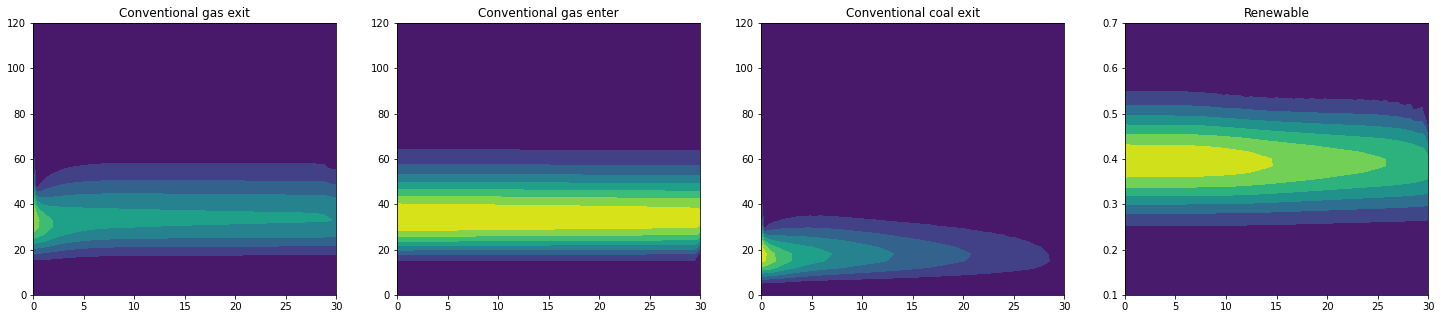

In [16]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newOm)
plt.title('Conventional gas exit')

plt.subplot(1,4,2)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newLamb)
plt.title('Conventional gas enter')

plt.subplot(1,4,3)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newMu)
plt.title('Conventional coal exit')

plt.subplot(1,4,4)
XX, YY = np.meshgrid(S, T)
plt.contourf(YY, XX, newEta)
plt.title('Renewable')

<ipython-input-9-25eb58102382>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('231')
<ipython-input-9-25eb58102382>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('232')
<ipython-input-9-25eb58102382>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('233')
<ipython-input-9-25eb58102382>:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
<ipython-input-9-25eb58102382>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is depr

Text(0.5, 1.0, 'Conventional installed capacity')

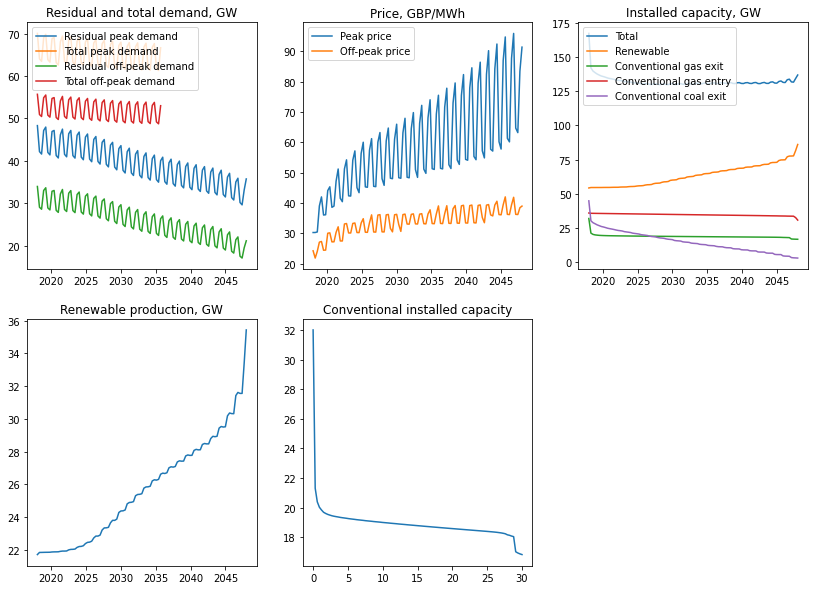

In [9]:
plt.figure(figsize=(14,10))

plt.subplot('231')
plt.plot(2018+T,RRp[:,Niter-1],label='Residual peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.plot(2018+T,RRop[:,Niter-1],label='Residual off-peak demand')
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.title('Residual and total demand, GW')
plt.legend(loc=2)

plt.subplot('232')
plt.plot(2018+T,prphist[:,Niter-1],label='Peak price')
plt.plot(2018+T,prophist[:,Niter-1],label='Off-peak price')
plt.legend(loc=2)
plt.title('Price, GBP/MWh')

plt.subplot('233')
renhist = np.ones(penhist.shape)*np.sum(BarEta)*dS-penhist
plt.plot(2018+T,renhist[:,Niter-1]+g_exit_hist[:,Niter-1]+g_enter_hist[:,Niter-1]+c_hist[:,Niter-1],label='Total')
plt.plot(2018+T,renhist[:,Niter-1],label='Renewable')
plt.plot(2018+T,g_exit_hist[:,Niter-1],label='Conventional gas exit')
plt.plot(2018+T,g_enter_hist[:,Niter-1],label='Conventional gas entry')
plt.plot(2018+T,c_hist[:,Niter-1],label='Conventional coal exit')
plt.legend(loc=2)
plt.title('Installed capacity, GW')

plt.subplot('234')
plt.plot(2018+T,np.sum(BarEta*S)*dS-renpen[:,Niter-1])
plt.title('Renewable production, GW')

#plt.savefig('industry_dynamics_peak_offpeak_baseline.pdf',format='pdf')

plt.subplot('235')
plt.plot(T,g_exit_hist[:,-1])
plt.title('Conventional installed capacity')

In [10]:
print(prphist[:,Niter-1])

[30.25315744 30.26041367 30.44121928 39.02605327 42.00116016 36.0299671
 36.11601673 44.07404646 45.33508503 38.56243856 38.96929697 47.17956362
 51.20688115 41.53185468 40.42559047 51.23131591 54.22636488 42.35318196
 42.28090214 54.12660303 57.17446636 45.04841322 43.39540063 56.35973026
 60.03535045 45.30738227 45.17438657 57.42076401 61.2232196  45.49255447
 45.38144383 60.03552509 63.23387441 48.0250463  45.81394612 60.45255537
 64.71942211 48.16723977 48.00858887 61.0385612  65.98337425 48.3294525
 48.14965687 63.13553515 67.94130307 48.48823842 48.30590706 64.52860965
 69.81878835 51.00837618 48.44398712 66.30729424 72.20648892 51.15893555
 49.77268742 68.04521518 74.04033441 51.30822684 51.06248723 69.36748474
 75.53777295 51.43104631 51.22851225 71.64395189 77.85953739 52.63610974
 51.36477693 73.00460872 79.59378466 54.18347879 52.7193425  75.50459161
 82.35648853 54.38500882 54.09471323 77.98243526 84.59464732 55.34257782
 54.26656054 79.55721779 86.44622081 57.20015551 54.8

In [11]:
print(prophist[:,Niter-1])

[24.22552417 21.8285524  24.0480156  27.08000041 27.29562225 24.40659129
 24.45296705 30.01177797 30.14544345 27.16764415 27.18597871 30.30100591
 32.14008433 27.46753025 27.46423566 33.06448144 33.22596461 30.11338992
 30.09356228 33.25012385 33.39663087 30.2494228  30.21860468 33.38792711
 34.81151202 30.35169023 30.31327132 33.4873555  36.07641963 30.42542546
 30.38455283 36.00720337 36.15013114 30.47367202 30.43439813 36.08226313
 36.21813306 31.61093225 30.47139835 36.10724178 36.25286427 32.88914513
 30.62760746 36.16548597 36.33235688 33.0547522  33.00577239 36.23845397
 36.40492591 33.10950338 33.05811614 36.30603094 36.47157086 33.15911377
 33.10526854 36.36562912 37.74834994 33.20956158 33.15035089 36.42111274
 39.02681553 33.25168603 33.19316996 36.48120842 39.09408738 33.29763049
 33.23843661 38.09678596 39.15630489 33.35459278 33.30322928 39.05862818
 39.24007331 33.41418372 33.35988184 39.13255184 39.31134517 33.47011441
 33.41203772 39.19189705 39.36930393 35.2127789  33

In [51]:
print(g_enter_hist[:,Niter-1])

[35.99985522 35.81153703 35.76664226 35.74409445 35.72206639 35.70031735
 35.67873264 35.65725344 35.63584746 35.61449582 35.5931868  35.57191276
 35.55066848 35.52945025 35.50825534 35.4870817  35.46592775 35.44479225
 35.42367419 35.40257278 35.38148735 35.36041737 35.33936239 35.31832202
 35.29729595 35.27628391 35.25528568 35.23430105 35.21332988 35.192372
 35.1714273  35.15049568 35.12957704 35.1086713  35.08777839 35.06689825
 35.04603083 35.02517607 35.00433395 34.98350442 34.96268744 34.94188299
 34.92109105 34.90031158 34.87954457 34.85879    34.83804784 34.81731809
 34.79660072 34.77589573 34.75520309 34.7345228  34.71385485 34.69319922
 34.6725559  34.65192488 34.63130616 34.61069972 34.59010555 34.56952365
 34.548954   34.5283966  34.50785144 34.48731851 34.46679781 34.44628932
 34.42579303 34.40530895 34.38483705 34.36437734 34.34392981 34.32349445
 34.30307124 34.28266019 34.26226129 34.24187452 34.22149989 34.20113738
 34.18078699 34.15918893 34.13823498 34.11797045 34.0

In [52]:
print(g_exit_hist[:,Niter-1])

[31.99987131 21.30212401 20.38273067 20.01994776 19.83501292 19.68016418
 19.59885101 19.53458012 19.48661364 19.44246279 19.4102332  19.38412672
 19.35947997 19.33174137 19.31077991 19.29127427 19.27131141 19.24919565
 19.23030882 19.21277625 19.19558508 19.17596382 19.16044522 19.14522652
 19.13001265 19.11082676 19.09631865 19.0825811  19.06863653 19.0518448
 19.03812258 19.02503722 19.01182802 18.99412682 18.98099302 18.96824684
 18.95537183 18.94009446 18.9274434  18.91508731 18.90217578 18.88695431
 18.87425391 18.86205209 18.84976989 18.83537963 18.82318544 18.81110833
 18.7989684  18.78556208 18.77300198 18.76126272 18.74939822 18.7359214
 18.72384628 18.7119881  18.70036316 18.68744701 18.67560396 18.66388663
 18.65213868 18.63984801 18.62826727 18.61665872 18.6050338  18.59340098
 18.58182656 18.5704826  18.55908905 18.54743326 18.53612113 18.52477675
 18.51343049 18.50208418 18.49088735 18.47966331 18.46841003 18.45699082
 18.44579629 18.43458018 18.42331548 18.41161429 18.4

In [53]:
print(c_hist[:,Niter-1])

[44.90047032 30.29370319 28.92582693 28.14756541 27.33013611 26.75059151
 26.14626704 25.80031059 25.36813738 24.88191103 24.5704058  24.28555935
 23.9686791  23.60279857 23.27459492 23.09088673 22.85708426 22.39896886
 22.1814203  21.97575614 21.74534774 21.27950394 21.06879324 20.86795231
 20.65189587 20.19376137 19.98726704 19.79915934 19.58976531 19.14764295
 18.84785417 18.69787069 18.51279675 18.0986613  17.81695848 17.67755366
 17.50599646 17.11270056 16.84607697 16.716325   16.55650686 15.94085956
 15.75136802 15.64171591 15.50511488 14.94443335 14.77247924 14.67314823
 14.5483488  14.0218583  13.85974653 13.76927365 13.65632943 13.17295586
 13.02000085 12.93653471 12.83462375 12.37396614 12.23379938 12.15795506
 12.07516712 11.62690297 11.4045942  11.34900504 11.29829214 10.8654237
 10.65427599 10.62129682 10.57282114  9.95835583  9.81180565  9.78396224
  9.74406289  9.19238705  9.06210626  9.03747463  9.00430455  8.47186373
  8.35249116  8.33072202  8.3107651   7.56714552  7.

In [54]:
print(renhist[:,Niter-1])

[54.29895728 54.62290002 54.62508289 54.63171936 54.63812611 54.64057973
 54.6463971  54.67696691 54.68994189 54.69433907 54.70342175 54.75919194
 54.79609726 54.79966395 54.81259002 54.94214324 54.99930775 55.01505073
 55.04836438 55.24052981 55.34554638 55.37698757 55.45728091 55.70855167
 55.85960926 55.90984909 56.0331174  56.41673111 56.65072282 56.69211441
 56.82871029 57.43169927 57.71456229 57.78108052 57.88447431 58.43759797
 58.77142187 58.83116346 59.02630667 59.83008383 60.07370021 60.16791681
 60.32910187 61.08546992 61.31883837 61.42294292 61.56878004 62.30037862
 62.52456033 62.62789564 62.76677691 63.46348584 63.68061379 63.78014487
 63.91450521 64.58185022 64.79054279 64.83721851 64.98875965 65.63234471
 65.83085772 65.87348768 66.02178773 66.64001997 66.83080278 66.87222231
 67.00348721 67.57584689 67.77010954 67.80966246 67.88565895 68.50936904
 68.69285346 68.71713743 68.78649925 69.38927524 69.57220921 69.58957771
 69.66022647 70.29895705 70.47335609 70.50333225 70